## Linear Regression with Gradient Descent

Linear regression problem solved with gradient descent algorithm.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

### Dataset
Dataset consists of data from 145 5-dimensional data points. Each data point represents an American power supply firm. The dimensions are:
* **TC**: Total cost
* **Q**: Output
* **PL**: Price of labor
* **PF**: Price of fuel
* **PK**: Price of capital

The dataset is from the year 1955.

In [2]:
# Read data set
df = pd.read_csv('nerlove.csv')
print('Shape of the dataset:', df.shape)
print('Number of missing values:', df.isna().sum().sum())
df.head()

Shape of the dataset: (145, 5)
Number of missing values: 0


,TC,Q,PL,PF,PK
0,0.082,2,2.09,17.9,183
1,0.661,3,2.05,35.1,174
2,0.990,4,2.05,35.1,171
3,0.315,4,1.83,32.2,166
4,0.197,5,2.12,28.6,233


### Problem formulation

Let's assume that the output of each firm, $Q$, can be derived from the following production 
function: </br>
$Q = F(L, F, K)$ </br>
If we assume a Cobb-Douglas technology, the production function would be: </br>
$F(L, F, K) ) = A \cdot L^\alpha \cdot F^\beta \cdot K^\gamma$ where $\alpha + \beta + \gamma = r$
and $A$ is the technology level of the firm. </br>

Thus the total cost function of a firm would be:
$TC = r \cdot (A \cdot \alpha^\alpha \beta^\beta \gamma^\gamma)^{-1/r} \cdot Q^{1/r} \cdot 
P_L^{\alpha/r} P_F^{\beta/r} P_K^{\gamma/r}$ </br>

From this, we can derive a log-log model: </br>
$loc(TC) = \mu + \dfrac{1}{r}log(Q) + \dfrac{\alpha}{r}log(P_L) + \dfrac{\beta}{r}log(P_F) + \dfrac{\gamma}{r}log(P_K)$ where $\mu$ is $log(A \cdot \alpha^\alpha \beta^\beta \gamma^\gamma)^{-1/r}$

From this, we get a linear regression model: </br>
$log(TC) = \beta + w_1 \cdot log(Q) + w_2 \cdot log(P_L) + w_3 \cdot log(P_F) + w_4 \cdot log(P_K) + \epsilon$

log(TC) (y-axis) vs. log(Q), log(PL), log(PF) & log(PK) (x-axis)


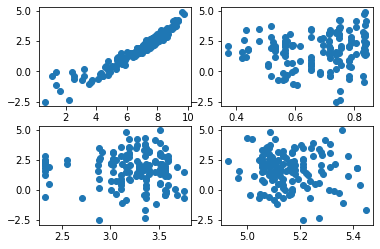

In [3]:
fig, ax = plt.subplots(nrows=2, ncols=2)

response_vars = [np.log(df['Q']), np.log(df['PL']), np.log(df['PF']), np.log(df['PK'])]

idx = 0
for row in ax:
    for col in row:
        col.scatter(response_vars[idx], np.log(df['TC']))
        idx += 1
print('log(TC) (y-axis) vs. log(Q), log(PL), log(PF) & log(PK) (x-axis)')
plt.show()

### Training the model

In [52]:
# Pandas to numpy
X = df[['Q', 'PL', 'PF', 'PK']].to_numpy()
X = np.log(X)
y = df['TC'].to_numpy()
y = np.log(y)
y = np.expand_dims(y, axis=1)

print(X.shape, y.shape)

(145, 4) (145, 1)


In [53]:
# Splitting the dataset
np.random.seed(0)

n = df.shape[0]
idx = np.arange(n)
np.random.shuffle(idx)
train_idx = idx[:int(0.8*n)]
test_idx = idx[int(0.8*n):]

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(116, 4) (116, 1) (29, 4) (29, 1)


In [54]:
# Initialization
np.random.seed(0)
b = np.random.randn(1)
w = np.random.randn(4)
print(b, w)

[1.76405235] [0.40015721 0.97873798 2.2408932  1.86755799]


In [55]:
# Scaling the data
scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(X_train)
sc_X_train = scaler.transform(X_train)
sc_X_test = scaler.transform(X_test)
print(sc_X_train.shape, sc_X_test.shape)

(116, 4) (29, 4)


Loss in round 0: 408.61128405455486
Loss in round 10: 181.28362732104563
Loss in round 20: 80.80424975673654
Loss in round 30: 36.39212031862591
Loss in round 40: 16.761851013214674
Loss in round 50: 8.085224202515054
Loss in round 60: 4.250134034322653
Loss in round 70: 2.555014845834685
Loss in round 80: 1.8057680388073605
Loss in round 90: 1.4745991265249314
Loss in round 99: 1.3380853685449525


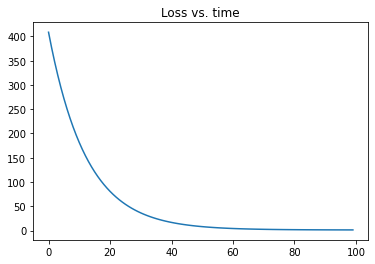

In [56]:
# The training process

lr = 0.02

def grad_desc_w(X_train, y_hat, y_train, idx):
    return 2 * np.mean(X_train[:, idx] * (y_hat - y_train))

def grad_desc_b(y_hat, y_train):
    return 2 * np.mean(y_hat - y_train)

def loss(y_train, y_hat):
    return np.sum(np.square(y_train - y_hat)) / len(y_hat)

n_rounds = 100
loss_vals = np.zeros(n_rounds)
for i in range(100):
    y_hat = b + w @ X_train.T
    y_hat = np.expand_dims(y_hat, axis=1)
    loss_i = loss(y_hat, y_train)
    loss_vals[i] = loss_i
    if i % 10 == 0 or i == n_rounds-1:
        print(f'Loss in round {i}:', loss_i)
    for i in range(len(w)):
        w[i] -= lr * grad_desc_w(sc_X_train, y_hat, y_train, i)
    b -= lr * grad_desc_b(y_hat, y_train)
plt.plot(np.arange(n_rounds), loss_vals)
plt.title('Loss vs. time')
plt.show()

### Sources
Dataset: http://fhayashi.fc2web.com/datasets.htm </br>
Problem formulation: F. Hayashi: Econometrics (2000) </br>